In [1]:
import pandas as pd

df = pd.read_csv('./data/cleaned_data.csv')
df.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Tech Support,Churn Value,Bank transfer (automatic),Credit card (automatic),Mailed check
0,1,0,0,0,-1.236724,1,0,0,1,0,0,1
1,0,0,0,1,-1.236724,1,0,0,1,0,0,0
2,0,0,0,1,-0.992402,1,1,0,1,0,0,0
3,0,0,1,1,-0.177995,1,1,1,1,0,0,0
4,1,0,0,1,0.677133,1,1,0,1,1,0,0


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
df.shape

(7043, 12)

In [4]:
models = {
    'Logistic Regression': LogisticRegression(n_jobs=-1),
    'SVC': SVC(probability=True),
    'Random Forest': RandomForestClassifier(n_jobs=-1),
}

In [5]:
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Churn Value'])
y = df['Churn Value']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from sklearn.metrics import (
    classification_report,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    average_precision_score,
    precision_recall_curve,
    PrecisionRecallDisplay,
    f1_score,
)


def test_model(model, X_train, X_test, y_train, y_test):
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"Classification Report")
    print(classification_report(y_test, y_pred))

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {roc_auc:.2f}")
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

    pr_auc = average_precision_score(y_test, y_pred)
    print(f"Precision Score: {pr_auc}")
    precision, recall, pre_thresholds = precision_recall_curve(y_test, y_prob)
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()

    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    
    print("-"*30, end="\n\n")

Classification Report
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1009
           1       0.67      0.48      0.56       400

    accuracy                           0.78      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.77      0.78      0.77      1409

ROC AUC Score: 0.82
Precision Score: 0.4672220106011802
F1 Score: 0.5568513119533528
------------------------------

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1009
           1       0.68      0.43      0.53       400

    accuracy                           0.78      1409
   macro avg       0.74      0.68      0.69      1409
weighted avg       0.77      0.78      0.76      1409

ROC AUC Score: 0.77
Precision Score: 0.4553089549044127
F1 Score: 0.5276073619631901
------------------------------

Classification Report
              precision    recall  f1-score   

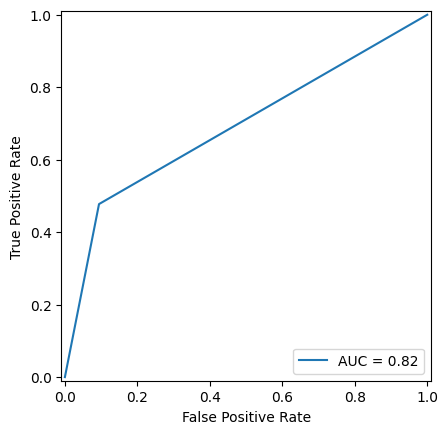

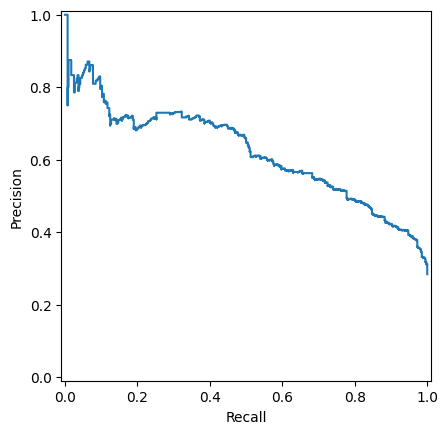

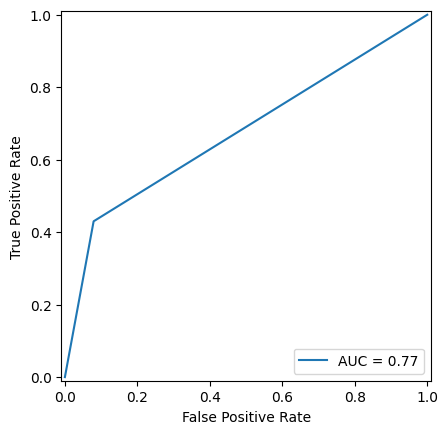

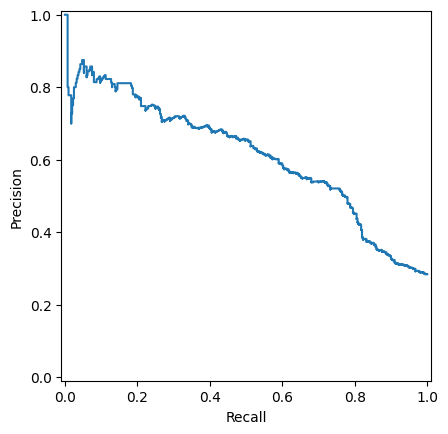

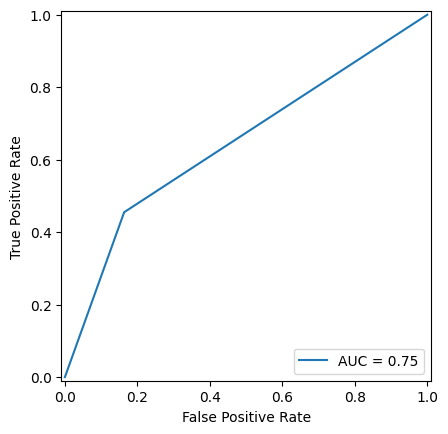

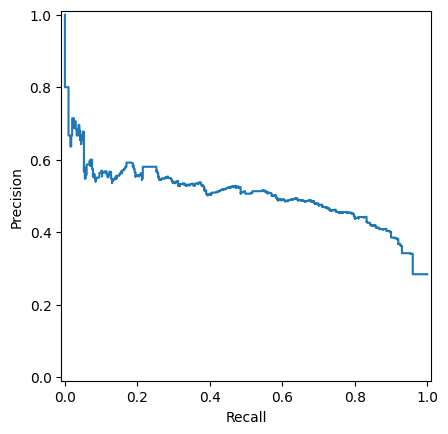

In [7]:
test_model(models['Logistic Regression'], X_train, X_test, y_train, y_test)
test_model(models['SVC'], X_train, X_test, y_train, y_test)
test_model(models['Random Forest'], X_train, X_test, y_train, y_test)

In [8]:
df['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

Since there is severe imbalance between number of instances in Churn Value, there is poor model performance.
- Majority Class (Churn Value = 0, Number of Instances = 5174)
- Minority Class ((Synthetic Minority Over-sampling Technique), Number of Instances = 1869)

Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic examples for minority class (Churn Value = 0)

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_resampled.shape)
print(y_resampled.shape)

(8330, 11)
(8330,)


For Logistic Regression:
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.72      0.79      1009
           1       0.52      0.76      0.62       400

    accuracy                           0.73      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.78      0.73      0.74      1409

ROC AUC Score: 0.82
Precision Score: 0.46253526094805864
F1 Score: 0.6164801627670397
------------------------------

For SVC:
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      1009
           1       0.51      0.77      0.61       400

    accuracy                           0.72      1409
   macro avg       0.70      0.74      0.70      1409
weighted avg       0.78      0.72      0.74      1409

ROC AUC Score: 0.81
Precision Score: 0.4571876079759815
F1 Score: 0.6130952380952381
------------------------------

For Random Forest:
Classification

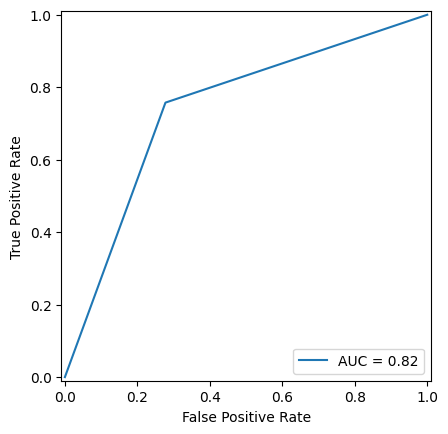

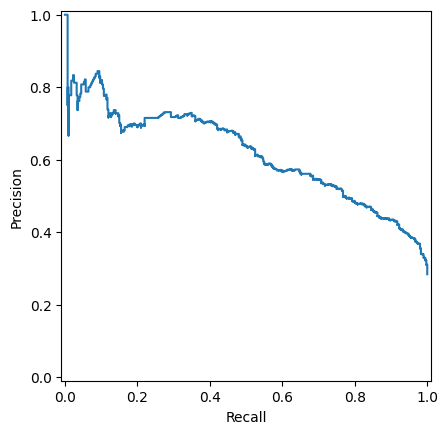

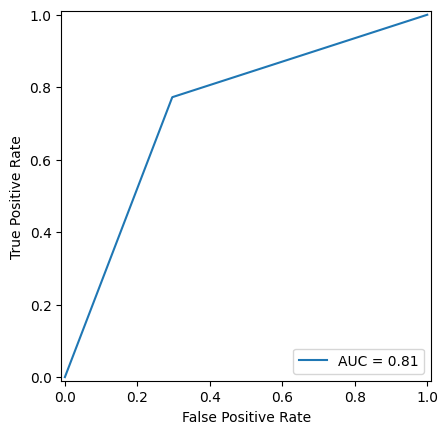

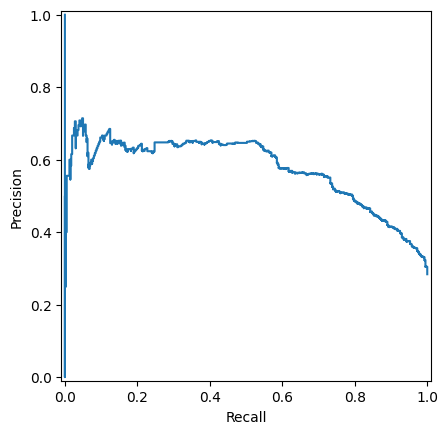

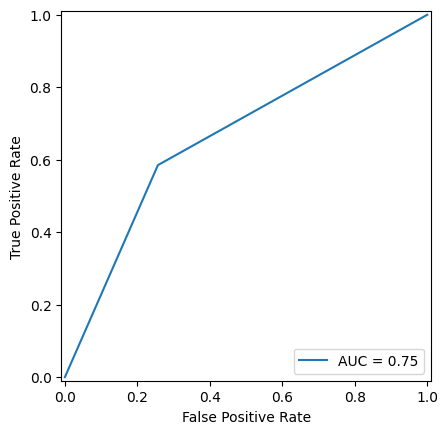

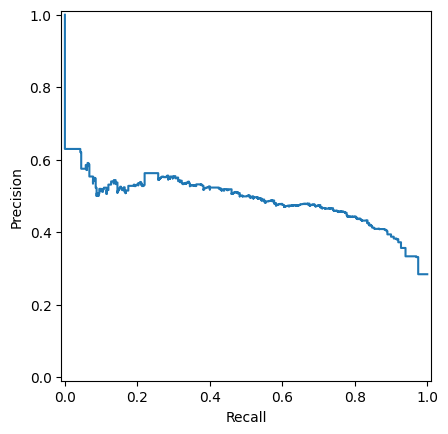

In [11]:
from imblearn.pipeline import Pipeline

for model_name, model in models.items():
    print(f"For {model_name}:")
    smote_pipeline = Pipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])
    test_model(smote_pipeline, X_train, X_test, y_train, y_test)

After applying SMOTE, the models' scores have improved. Random Forest appears to be the best.

In [12]:
# model__ : prefix to indicate they= params belong to the model step
# C: Regularization strength
# solver: Solvers
# max_iter: Maximum number of iterations
# kernel: Kernel function
# gamma: Kernel coefficient
# degree: Polynomial kernel degree (if using 'poly')
# n_estimators: Number of trees
# max_depth: Maximum depth of trees
# min_samples_split: Minimum samples required to split an internal node
# min_samples_leaf: Minimum samples required to be a leaf node
# bootstrap: Whether to use bootstrap sampling

param_grid = {
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__solver": ["liblinear", "saga"],
        "model__max_iter": [100, 200, 300],
    },
    "SVC": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__kernel": ["linear", "rbf"],
        "model__gamma": ["scale", "auto"],
        "model__degree": [3, 4, 5],
    },
    "Random Forest": {
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [None, 10, 20, 30],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4],
        "model__bootstrap": [True, False],
    },
}

In [13]:
from sklearn.model_selection import StratifiedKFold

stratified_KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_result = {}
for model_name, model in models.items():
    smote_pipeline = Pipeline([("smote", SMOTE(random_state=42)), ("model", model)])

    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=smote_pipeline,
        param_grid=param_grid[model_name],
        cv=stratified_KFold,
        n_jobs=-1,
        verbose=1,
        scoring='f1'
    )
    grid_search.fit(X_resampled, y_resampled)

    best_result[model_name] = {
        "hyperparameters": grid_search.best_params_,
        "score": grid_search.best_score_,
    }

# This ran for about 3 minutes

Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 

Performing Grid Search for SVC...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Performing Grid Search for Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [14]:
for model_name, best_params in best_result.items():
    print(f"Best Hyperparameters for {model_name}: {best_params['hyperparameters']}")
    print(f"Best Score for {model_name}: {best_params['score']}")
    print()

Best Hyperparameters for Logistic Regression: {'model__C': 100, 'model__max_iter': 100, 'model__solver': 'liblinear'}
Best Score for Logistic Regression: 0.7625148522221995

Best Hyperparameters for SVC: {'model__C': 100, 'model__degree': 3, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Score for SVC: 0.7864214791169435

Best Hyperparameters for Random Forest: {'model__bootstrap': False, 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}
Best Score for Random Forest: 0.8019415443365625



Classification Report
              precision    recall  f1-score   support

           0       0.87      0.73      0.79      1009
           1       0.51      0.72      0.60       400

    accuracy                           0.72      1409
   macro avg       0.69      0.72      0.69      1409
weighted avg       0.77      0.72      0.74      1409

ROC AUC Score: 0.81
Precision Score: 0.44660886484698015
F1 Score: 0.5966735966735967
------------------------------



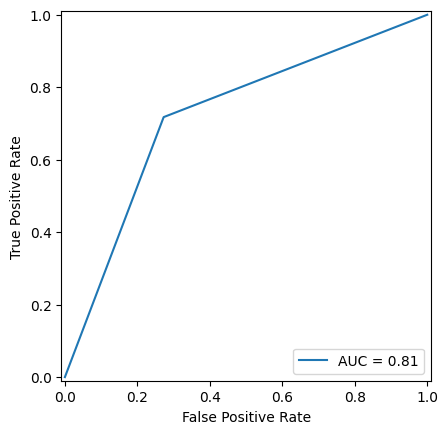

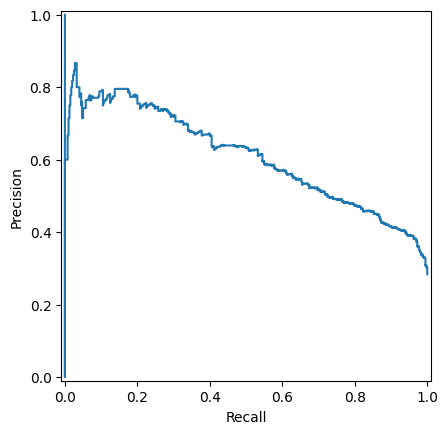

In [15]:
# Random Forest appears to be the best model
best_params_rf = best_result["Random Forest"]["hyperparameters"]
cleaned_best_params = {
    key.replace("model__", ""): value for key, value in best_params_rf.items()
}

model = RandomForestClassifier(n_jobs=-1, **cleaned_best_params)

smote_pipeline = Pipeline([("smote", SMOTE(random_state=42)), ("model", model)])

test_model(smote_pipeline, X_train, X_test, y_train, y_test)

In [16]:
best_params_rf = best_result["Random Forest"]["hyperparameters"]
best_params_rf

{'model__bootstrap': False,
 'model__max_depth': 10,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Adding PCA to pipeline

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      1009
           1       0.50      0.71      0.59       400

    accuracy                           0.72      1409
   macro avg       0.68      0.71      0.68      1409
weighted avg       0.76      0.72      0.73      1409

ROC AUC Score: 0.79
Precision Score: 0.4367039905403501
F1 Score: 0.586171310629515
------------------------------

F1 Score: 0.586171310629515
Accuracy: 0.7154009936124911


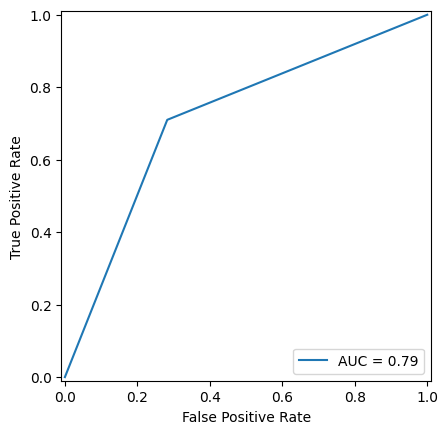

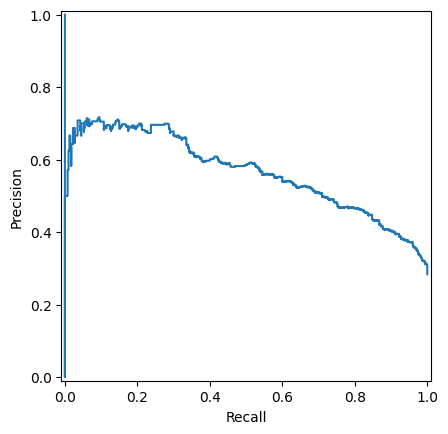

In [17]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA

best_params_rf = best_result["Random Forest"]["hyperparameters"]
cleaned_best_params = {
    key.replace("model__", ""): value for key, value in best_params_rf.items()
}

pca = PCA(n_components=0.95)
model = RandomForestClassifier(n_jobs=-1, **cleaned_best_params)

smote_pca_pipeline = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ('PCA', pca),
    ("model", model)])

test_model(smote_pca_pipeline, X_train, X_test, y_train, y_test)


# Get predictions
y_pred = smote_pca_pipeline.predict(X_test)

# Calculate metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Running GridSearchCV with SMOTE, PCA Pipeline

In [18]:
from sklearn.model_selection import StratifiedKFold

stratified_KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_result = {}
for model_name, model in models.items():
    smote_pca_pipeline = Pipeline(
        [("smote", SMOTE(random_state=42)), ("PCA", pca), ("model", model)]
    )

    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(
        estimator=smote_pca_pipeline,
        param_grid=param_grid[model_name],
        cv=stratified_KFold,
        n_jobs=-1,
        verbose=1,
        scoring="f1",
    )
    grid_search.fit(X_resampled, y_resampled)

    best_result[model_name] = {
        "hyperparameters": grid_search.best_params_,
        "score": grid_search.best_score_,
    }

# This ran for about 5 minutes

Performing Grid Search for Logistic Regression...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 32.
  warnings.warn(
/home/oak/coding/practice/machine-learning/churn-prediction/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 

Performing Grid Search for SVC...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Performing Grid Search for Random Forest...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [19]:
for model_name, best_params in best_result.items():
    print(f"Best Hyperparameters for {model_name}: {best_params['hyperparameters']}")
    print(f"Best Score for {model_name}: {best_params['score']}")
    print()

Best Hyperparameters for Logistic Regression: {'model__C': 1, 'model__max_iter': 100, 'model__solver': 'liblinear'}
Best Score for Logistic Regression: 0.7598906835016136

Best Hyperparameters for SVC: {'model__C': 100, 'model__degree': 3, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Best Score for SVC: 0.7883392696669095

Best Hyperparameters for Random Forest: {'model__bootstrap': False, 'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best Score for Random Forest: 0.8066825513322586



Classification Report
              precision    recall  f1-score   support

           0       0.86      0.72      0.79      1009
           1       0.51      0.71      0.59       400

    accuracy                           0.72      1409
   macro avg       0.69      0.72      0.69      1409
weighted avg       0.76      0.72      0.73      1409

ROC AUC Score: 0.79
Precision Score: 0.44283764924599756
F1 Score: 0.5927461139896373
------------------------------



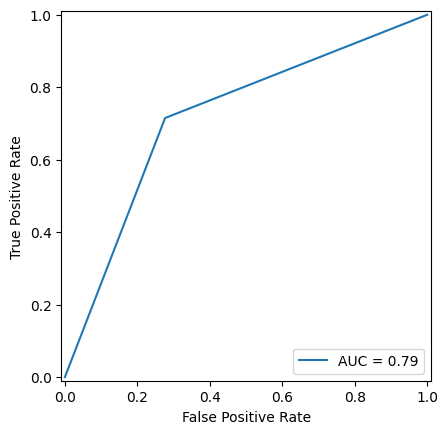

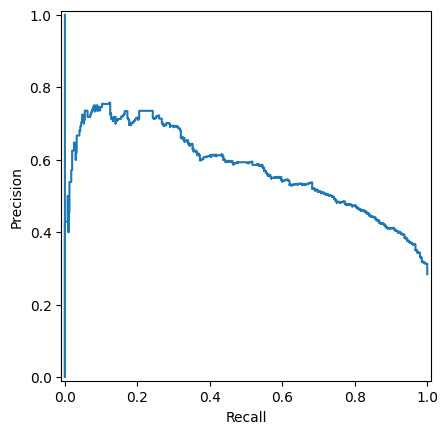

In [22]:
# Again, Random Forest appears to be the best model
best_params_rf = best_result["Random Forest"]["hyperparameters"]
cleaned_best_params = {
    key.replace("model__", ""): value for key, value in best_params_rf.items()
}

model = RandomForestClassifier(n_jobs=-1, **cleaned_best_params)

smote_pca_pipeline = Pipeline(
        [("smote", SMOTE(random_state=42)), ("PCA", pca), ("model", model)]
    )

test_model(smote_pca_pipeline, X_train, X_test, y_train, y_test)

In [23]:
smote_pca_pipeline.score(X_test, y_test)

0.7210787792760823

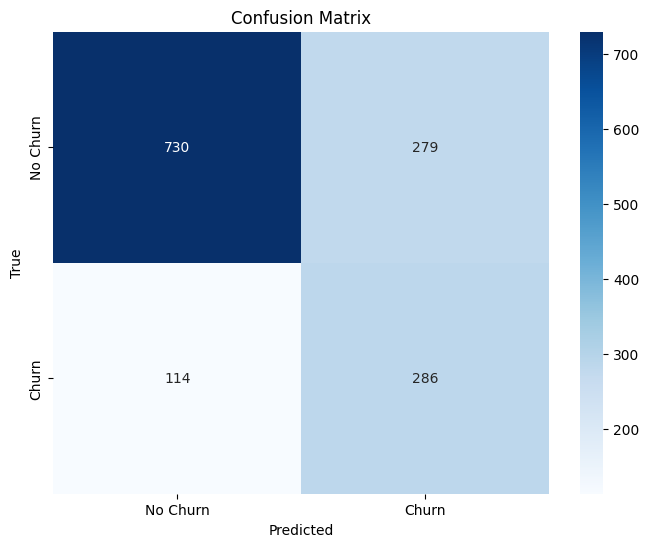

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = smote_pca_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()